In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Define the MobileNetV2 model
def mobilenetv2_model(input_size=(128, 128, 3), num_classes=6):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_size)
    
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the layers

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [3]:
# Load data using ImageDataGenerator
def load_data():
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Use 20% for validation
    
    train_generator = datagen.flow_from_directory(
        'D:/Apgama/archive/NEU Metal Surface Defects Data/train',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',  
        subset='training'
    )

    valid_generator = datagen.flow_from_directory(
        'D:/Apgama/archive/NEU Metal Surface Defects Data/valid',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',  
        subset='validation'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        'D:/Apgama/archive/NEU Metal Surface Defects Data/test',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical'  
    )

    return train_generator, valid_generator, test_generator


In [4]:
# Prediction function
def predict_image(model, image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
    input_array = tf.keras.preprocessing.image.img_to_array(image)
    input_array = np.expand_dims(input_array, axis=0) / 255.0
    
    prediction = model.predict(input_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    # Map the predicted class to the actual label
    class_labels = list(test_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class]
    
    # Display the original image and the prediction result
    plt.imshow(image)
    plt.title(f'Prediction: {predicted_label}')
    plt.show()


In [5]:
# Create and summarize the model
model = mobilenetv2_model()
model.summary()

# Load data
train_generator, valid_generator, test_generator = load_data()

# Train the model
model.fit(train_generator, epochs=20, validation_data=valid_generator, 
          steps_per_epoch=train_generator.samples // train_generator.batch_size, 
          validation_steps=valid_generator.samples // valid_generator.batch_size)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 7,502,662
Trainable params: 5,244,678
Non-trainable params: 2,257,984
______________________________________

In [6]:
# Save the trained model
model.save('mobilenetv2_metal_surface_defects_model.h5')


In [7]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}')


3/3 [==============================] - 1s 118ms/step - loss: 1.1469e-04 - accuracy: 1.0000
Test accuracy: 1.00


1/1 [==============================] - 1s 559ms/step


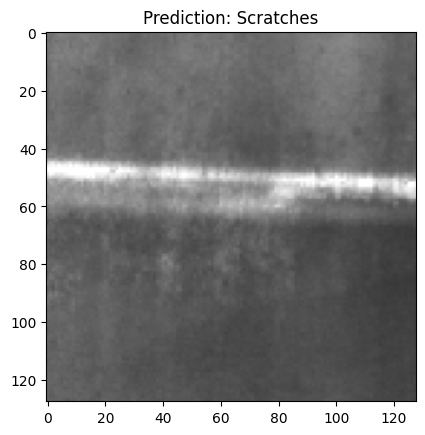

1/1 [==============================] - 0s 28ms/step


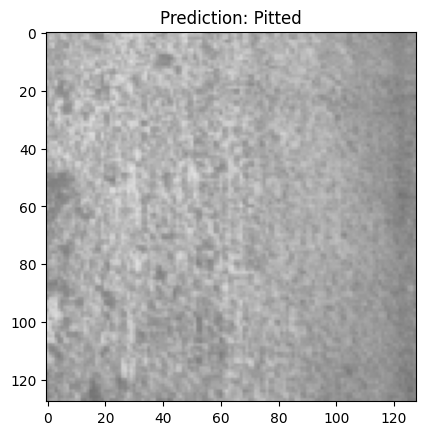

1/1 [==============================] - 0s 27ms/step


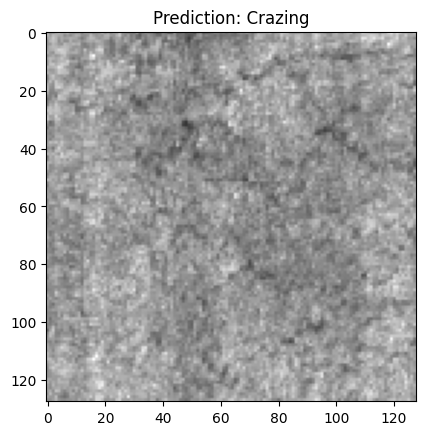

1/1 [==============================] - 0s 24ms/step


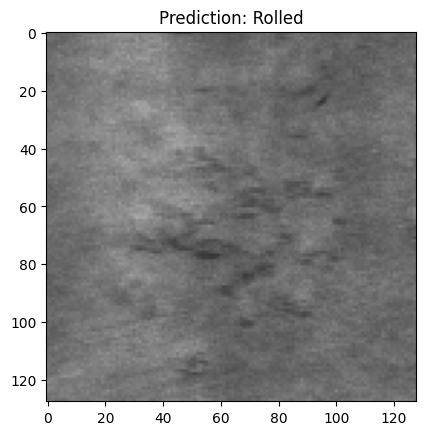

In [8]:
# Load the saved model (when you want to use it for predictions)
model = load_model('mobilenetv2_metal_surface_defects_model.h5')
# Test the prediction with sample images
predict_image(model, r"D:\Apgama\archive\NEU Metal Surface Defects Data\test\Scratches\Sc_101.bmp")
predict_image(model, r"D:\Apgama\archive\NEU Metal Surface Defects Data\test\Pitted\PS_105.bmp")
predict_image(model, r"D:\Apgama\archive\NEU Metal Surface Defects Data\test\Crazing\Cr_101.bmp")
predict_image(model, r"D:\Apgama\archive\NEU Metal Surface Defects Data\test\Rolled\RS_104.bmp")
